In [6]:
#Multiple Input Multi-Step Output
#https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/

In [7]:
# multivariate multi-step 1d cnn example
from numpy import hstack
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from func1 import *
from query2 import *
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np

In [8]:
df = data1()
print("raw of shape ", df.shape)
df.index = df['datetime']
df.index = df.index.astype('datetime64[ns]')
df.sort_index(inplace=True)
df.dropna(inplace=True)
df['datetime'] = pd.to_datetime(df['datetime'])

print("dropna ", df.shape)

raw of shape  (5993, 33)
dropna  (4412, 33)


In [48]:
# rawdata = df[['stor']].iloc[4009:,:]
# print(rawdata.shape)
# rawdata.to_csv('rawdata.csv')

In [9]:
dtat0 = df.iloc[-1:,0:1].values[0][0]
dti = pd.date_range(dtat0, periods=7).shift(1, freq='D')
dfdt = dti.to_frame(index=False, name='datims')
df.drop(('datetime'), axis=1, inplace=True)
# dfdt

In [10]:
dfdt

,datims
0,2020-06-08
1,2020-06-09
2,2020-06-10
3,2020-06-11
4,2020-06-12
5,2020-06-13
6,2020-06-14


In [11]:
# df.drop(('datetime'), axis=1, inplace=True)

In [12]:
from sklearn.preprocessing import MinMaxScaler
y_scaler = MinMaxScaler()
y_scaler.fit(df[['fore24']])

X_scaler = MinMaxScaler()

df[['tail24', 'tail24_avg', 'evap', 'infl', 'losses',
       'rel1', 'rel2', 'rel3', 'rel_tol', 'engr1', 'engr2', 'engr3', 'cond1',
       'cond2', 'cond3', 'str1', 'str2', 'str3', 'run_g1', 'run_g2', 'run_g3',
       'run_c1', 'run_c2', 'run_c3', 'spillway', 'irr', 'camp', 'demand',
       'derate', 'outage', 'stor','fore24']] = X_scaler.fit_transform(df)

In [53]:
df.tail(2)

,tail24,tail24_avg,evap,infl,losses,rel1,rel2,rel3,rel_tol,engr1,...,run_c2,run_c3,spillway,irr,camp,demand,derate,outage,stor,fore24
datetime,,,,,,,,,,,,,,,,,,,,,
2020-06-04,0.658926,0.948446,0.116066,0.005276,0.000000,0.264385,0.294356,0.369869,0.309895,0.215000,...,0.056699,0.068963,0.0,0.0,0.754887,0.224138,0.833333,0.0,0.125961,0.163445
2020-06-05,0.806967,0.945800,0.114351,0.000000,0.350086,0.282776,0.320080,0.276349,0.293471,0.226667,...,0.056699,0.068963,0.0,0.0,0.944510,0.206897,0.833333,0.0,0.122625,0.159344


In [54]:
dfval = df.values
print(dfval.shape) # (1000, 30) = (sample, features)

(4410, 32)


In [55]:
n_steps_in, n_steps_out = 10, 7

# convert into input/output
X, y = split_sequences(dfval, n_steps_in, n_steps_out)
print(X.shape)

X_train = X[:4000,:]
X_test = X[4000:,:]

y_train = y[:4000,:]
y_test = y[4000:,:]


print('X_train', X_train.shape) # (4000, 10, 31) = (samples, n_steps_in, n_features)
print('X_test', X_test.shape) # (390, 10, 31) = (samples, n_steps_in, n_features)

print('y_train',y_train.shape) # (4000, 7) = (samples, n_steps_out)
print('y_test',y_test.shape) # (390, 7) = (samples, n_steps_out)

n_features = X.shape[2]

(4395, 10, 31)
X_train (4000, 10, 31)
X_test (395, 10, 31)
y_train (4000, 7)
y_test (395, 7)


In [56]:
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

In [57]:
# fit model
save_path = 'models/'
filepath=save_path+"m{epoch:02d}.hdf5"
checkpointer = ModelCheckpoint(monitor='val_loss', filepath=filepath, verbose=1, save_best_only=True)
history = model.fit(X_train, y_train, validation_split=0.2, batch_size=64, epochs=1000, verbose=1, callbacks=[checkpointer])

Train on 3200 samples, validate on 800 samples
Epoch 1/1000
3200/3200 [==============================] - 1s 231us/step - loss: 0.0956 - val_loss: 0.0545

Epoch 00001: val_loss improved from inf to 0.05453, saving model to models/m01.hdf5
Epoch 2/1000
3200/3200 [==============================] - 0s 117us/step - loss: 0.0068 - val_loss: 0.0266

Epoch 00002: val_loss improved from 0.05453 to 0.02656, saving model to models/m02.hdf5
Epoch 3/1000
3200/3200 [==============================] - 0s 114us/step - loss: 0.0030 - val_loss: 0.0216

Epoch 00003: val_loss improved from 0.02656 to 0.02160, saving model to models/m03.hdf5
Epoch 4/1000
3200/3200 [==============================] - 0s 125us/step - loss: 0.0022 - val_loss: 0.0186

Epoch 00004: val_loss improved from 0.02160 to 0.01862, saving model to models/m04.hdf5
Epoch 5/1000
3200/3200 [==============================] - 0s 140us/step - loss: 0.0018 - val_loss: 0.0174

Epoch 00005: val_loss improved from 0.01862 to 0.01744, saving model t

3200/3200 [==============================] - 0s 128us/step - loss: 7.1027e-04 - val_loss: 0.0085

Epoch 00046: val_loss improved from 0.00886 to 0.00852, saving model to models/m46.hdf5
Epoch 47/1000
3200/3200 [==============================] - 0s 142us/step - loss: 7.3258e-04 - val_loss: 0.0099

Epoch 00047: val_loss did not improve from 0.00852
Epoch 48/1000
3200/3200 [==============================] - 0s 132us/step - loss: 7.0619e-04 - val_loss: 0.0090

Epoch 00048: val_loss did not improve from 0.00852
Epoch 49/1000
3200/3200 [==============================] - 0s 139us/step - loss: 6.8732e-04 - val_loss: 0.0092

Epoch 00049: val_loss did not improve from 0.00852
Epoch 50/1000
3200/3200 [==============================] - 0s 150us/step - loss: 6.9200e-04 - val_loss: 0.0078

Epoch 00050: val_loss improved from 0.00852 to 0.00785, saving model to models/m50.hdf5
Epoch 51/1000
3200/3200 [==============================] - 0s 139us/step - loss: 7.1572e-04 - val_loss: 0.0085

Epoch 00051: 

3200/3200 [==============================] - 0s 133us/step - loss: 6.1037e-04 - val_loss: 0.0072

Epoch 00094: val_loss did not improve from 0.00664
Epoch 95/1000
3200/3200 [==============================] - 0s 130us/step - loss: 5.9862e-04 - val_loss: 0.0073

Epoch 00095: val_loss did not improve from 0.00664
Epoch 96/1000
3200/3200 [==============================] - 0s 152us/step - loss: 6.7121e-04 - val_loss: 0.0068

Epoch 00096: val_loss did not improve from 0.00664
Epoch 97/1000
3200/3200 [==============================] - 0s 127us/step - loss: 6.3596e-04 - val_loss: 0.0073

Epoch 00097: val_loss did not improve from 0.00664
Epoch 98/1000
3200/3200 [==============================] - 0s 129us/step - loss: 6.1254e-04 - val_loss: 0.0069

Epoch 00098: val_loss did not improve from 0.00664
Epoch 99/1000
3200/3200 [==============================] - 0s 137us/step - loss: 6.1379e-04 - val_loss: 0.0069

Epoch 00099: val_loss did not improve from 0.00664
Epoch 100/1000
3200/3200 [==========

3200/3200 [==============================] - 0s 129us/step - loss: 5.6113e-04 - val_loss: 0.0068

Epoch 00143: val_loss did not improve from 0.00567
Epoch 144/1000
3200/3200 [==============================] - 0s 132us/step - loss: 5.9982e-04 - val_loss: 0.0059

Epoch 00144: val_loss did not improve from 0.00567
Epoch 145/1000
3200/3200 [==============================] - 0s 137us/step - loss: 5.9134e-04 - val_loss: 0.0068

Epoch 00145: val_loss did not improve from 0.00567
Epoch 146/1000
3200/3200 [==============================] - 0s 137us/step - loss: 6.1927e-04 - val_loss: 0.0074

Epoch 00146: val_loss did not improve from 0.00567
Epoch 147/1000
3200/3200 [==============================] - 0s 136us/step - loss: 5.9047e-04 - val_loss: 0.0061

Epoch 00147: val_loss did not improve from 0.00567
Epoch 148/1000
3200/3200 [==============================] - 0s 139us/step - loss: 5.5467e-04 - val_loss: 0.0058

Epoch 00148: val_loss did not improve from 0.00567
Epoch 149/1000
3200/3200 [=====

3200/3200 [==============================] - 0s 136us/step - loss: 4.7779e-04 - val_loss: 0.0061

Epoch 00193: val_loss did not improve from 0.00549
Epoch 194/1000
3200/3200 [==============================] - 0s 140us/step - loss: 5.2524e-04 - val_loss: 0.0053

Epoch 00194: val_loss improved from 0.00549 to 0.00534, saving model to models/m194.hdf5
Epoch 195/1000
3200/3200 [==============================] - 0s 139us/step - loss: 5.4961e-04 - val_loss: 0.0054

Epoch 00195: val_loss did not improve from 0.00534
Epoch 196/1000
3200/3200 [==============================] - 0s 138us/step - loss: 4.9435e-04 - val_loss: 0.0062

Epoch 00196: val_loss did not improve from 0.00534
Epoch 197/1000
3200/3200 [==============================] - 0s 133us/step - loss: 5.5370e-04 - val_loss: 0.0061

Epoch 00197: val_loss did not improve from 0.00534
Epoch 198/1000
3200/3200 [==============================] - 0s 150us/step - loss: 4.7311e-04 - val_loss: 0.0066

Epoch 00198: val_loss did not improve from 0

3200/3200 [==============================] - 0s 137us/step - loss: 4.9576e-04 - val_loss: 0.0065

Epoch 00292: val_loss did not improve from 0.00482
Epoch 293/1000
3200/3200 [==============================] - 0s 135us/step - loss: 4.9492e-04 - val_loss: 0.0050

Epoch 00293: val_loss did not improve from 0.00482
Epoch 294/1000
3200/3200 [==============================] - 0s 139us/step - loss: 4.4256e-04 - val_loss: 0.0056

Epoch 00294: val_loss did not improve from 0.00482
Epoch 295/1000
3200/3200 [==============================] - 0s 137us/step - loss: 4.2638e-04 - val_loss: 0.0057

Epoch 00295: val_loss did not improve from 0.00482
Epoch 296/1000
3200/3200 [==============================] - 0s 137us/step - loss: 4.4201e-04 - val_loss: 0.0050

Epoch 00296: val_loss did not improve from 0.00482
Epoch 297/1000
3200/3200 [==============================] - 0s 141us/step - loss: 4.4023e-04 - val_loss: 0.0055

Epoch 00297: val_loss did not improve from 0.00482
Epoch 298/1000
3200/3200 [=====

3200/3200 [==============================] - 0s 133us/step - loss: 2.1566e-04 - val_loss: 0.0048

Epoch 00390: val_loss did not improve from 0.00390
Epoch 391/1000
3200/3200 [==============================] - 0s 137us/step - loss: 1.9076e-04 - val_loss: 0.0045

Epoch 00391: val_loss did not improve from 0.00390
Epoch 392/1000
3200/3200 [==============================] - 0s 141us/step - loss: 2.7596e-04 - val_loss: 0.0052

Epoch 00392: val_loss did not improve from 0.00390
Epoch 393/1000
3200/3200 [==============================] - 0s 125us/step - loss: 2.2288e-04 - val_loss: 0.0043

Epoch 00393: val_loss did not improve from 0.00390
Epoch 394/1000
3200/3200 [==============================] - 0s 141us/step - loss: 2.1127e-04 - val_loss: 0.0046

Epoch 00394: val_loss did not improve from 0.00390
Epoch 395/1000
3200/3200 [==============================] - 0s 141us/step - loss: 3.0707e-04 - val_loss: 0.0045

Epoch 00395: val_loss did not improve from 0.00390
Epoch 396/1000
3200/3200 [=====

3200/3200 [==============================] - 0s 135us/step - loss: 1.3193e-04 - val_loss: 0.0044

Epoch 00440: val_loss did not improve from 0.00390
Epoch 441/1000
3200/3200 [==============================] - 0s 137us/step - loss: 1.2905e-04 - val_loss: 0.0047

Epoch 00441: val_loss did not improve from 0.00390
Epoch 442/1000
3200/3200 [==============================] - 0s 133us/step - loss: 1.2030e-04 - val_loss: 0.0042

Epoch 00442: val_loss did not improve from 0.00390
Epoch 443/1000
3200/3200 [==============================] - 0s 137us/step - loss: 1.4194e-04 - val_loss: 0.0048

Epoch 00443: val_loss did not improve from 0.00390
Epoch 444/1000
3200/3200 [==============================] - 0s 137us/step - loss: 1.6762e-04 - val_loss: 0.0045

Epoch 00444: val_loss did not improve from 0.00390
Epoch 445/1000
3200/3200 [==============================] - 0s 139us/step - loss: 2.0659e-04 - val_loss: 0.0048

Epoch 00445: val_loss did not improve from 0.00390
Epoch 446/1000
3200/3200 [=====

3200/3200 [==============================] - 0s 138us/step - loss: 9.2834e-05 - val_loss: 0.0043

Epoch 00490: val_loss did not improve from 0.00390
Epoch 491/1000
3200/3200 [==============================] - 0s 139us/step - loss: 1.2537e-04 - val_loss: 0.0052

Epoch 00491: val_loss did not improve from 0.00390
Epoch 492/1000
3200/3200 [==============================] - 0s 139us/step - loss: 2.4002e-04 - val_loss: 0.0041

Epoch 00492: val_loss did not improve from 0.00390
Epoch 493/1000
3200/3200 [==============================] - 0s 135us/step - loss: 2.0989e-04 - val_loss: 0.0044

Epoch 00493: val_loss did not improve from 0.00390
Epoch 494/1000
3200/3200 [==============================] - 0s 133us/step - loss: 1.8752e-04 - val_loss: 0.0052

Epoch 00494: val_loss did not improve from 0.00390
Epoch 495/1000
3200/3200 [==============================] - 0s 136us/step - loss: 1.7023e-04 - val_loss: 0.0044

Epoch 00495: val_loss did not improve from 0.00390
Epoch 496/1000
3200/3200 [=====

3200/3200 [==============================] - 0s 148us/step - loss: 7.2362e-05 - val_loss: 0.0055

Epoch 00540: val_loss did not improve from 0.00390
Epoch 541/1000
3200/3200 [==============================] - 0s 136us/step - loss: 7.4802e-05 - val_loss: 0.0056

Epoch 00541: val_loss did not improve from 0.00390
Epoch 542/1000
3200/3200 [==============================] - 0s 140us/step - loss: 7.4516e-05 - val_loss: 0.0049

Epoch 00542: val_loss did not improve from 0.00390
Epoch 543/1000
3200/3200 [==============================] - 0s 130us/step - loss: 7.3794e-05 - val_loss: 0.0052

Epoch 00543: val_loss did not improve from 0.00390
Epoch 544/1000
3200/3200 [==============================] - 0s 128us/step - loss: 7.2924e-05 - val_loss: 0.0051

Epoch 00544: val_loss did not improve from 0.00390
Epoch 545/1000
3200/3200 [==============================] - 0s 116us/step - loss: 7.9571e-05 - val_loss: 0.0053

Epoch 00545: val_loss did not improve from 0.00390
Epoch 546/1000
3200/3200 [=====

3200/3200 [==============================] - 0s 113us/step - loss: 4.0854e-04 - val_loss: 0.0056

Epoch 00640: val_loss did not improve from 0.00390
Epoch 641/1000
3200/3200 [==============================] - 0s 138us/step - loss: 5.8320e-04 - val_loss: 0.0047

Epoch 00641: val_loss did not improve from 0.00390
Epoch 642/1000
3200/3200 [==============================] - 0s 138us/step - loss: 5.1973e-04 - val_loss: 0.0046

Epoch 00642: val_loss did not improve from 0.00390
Epoch 643/1000
3200/3200 [==============================] - 0s 139us/step - loss: 4.4080e-04 - val_loss: 0.0051

Epoch 00643: val_loss did not improve from 0.00390
Epoch 644/1000
3200/3200 [==============================] - 0s 142us/step - loss: 4.2446e-04 - val_loss: 0.0058

Epoch 00644: val_loss did not improve from 0.00390
Epoch 645/1000
3200/3200 [==============================] - 0s 148us/step - loss: 4.1258e-04 - val_loss: 0.0058

Epoch 00645: val_loss did not improve from 0.00390
Epoch 646/1000
3200/3200 [=====

3200/3200 [==============================] - 0s 138us/step - loss: 6.2424e-05 - val_loss: 0.0050

Epoch 00690: val_loss did not improve from 0.00390
Epoch 691/1000
3200/3200 [==============================] - 0s 135us/step - loss: 6.0091e-05 - val_loss: 0.0049

Epoch 00691: val_loss did not improve from 0.00390
Epoch 692/1000
3200/3200 [==============================] - 0s 137us/step - loss: 1.2082e-04 - val_loss: 0.0045

Epoch 00692: val_loss did not improve from 0.00390
Epoch 693/1000
3200/3200 [==============================] - 0s 143us/step - loss: 2.6628e-04 - val_loss: 0.0038

Epoch 00693: val_loss improved from 0.00390 to 0.00379, saving model to models/m693.hdf5
Epoch 694/1000
3200/3200 [==============================] - 0s 138us/step - loss: 2.8390e-04 - val_loss: 0.0063

Epoch 00694: val_loss did not improve from 0.00379
Epoch 695/1000
3200/3200 [==============================] - 0s 142us/step - loss: 1.8439e-04 - val_loss: 0.0048

Epoch 00695: val_loss did not improve from 0

3200/3200 [==============================] - 0s 138us/step - loss: 1.2314e-04 - val_loss: 0.0053

Epoch 00740: val_loss did not improve from 0.00379
Epoch 741/1000
3200/3200 [==============================] - 0s 135us/step - loss: 2.7400e-04 - val_loss: 0.0056

Epoch 00741: val_loss did not improve from 0.00379
Epoch 742/1000
3200/3200 [==============================] - 0s 137us/step - loss: 1.1051e-04 - val_loss: 0.0053

Epoch 00742: val_loss did not improve from 0.00379
Epoch 743/1000
3200/3200 [==============================] - 0s 137us/step - loss: 7.4043e-05 - val_loss: 0.0050

Epoch 00743: val_loss did not improve from 0.00379
Epoch 744/1000
3200/3200 [==============================] - 0s 140us/step - loss: 5.3581e-05 - val_loss: 0.0053

Epoch 00744: val_loss did not improve from 0.00379
Epoch 745/1000
3200/3200 [==============================] - 0s 140us/step - loss: 4.9422e-05 - val_loss: 0.0052

Epoch 00745: val_loss did not improve from 0.00379
Epoch 746/1000
3200/3200 [=====

3200/3200 [==============================] - 0s 140us/step - loss: 2.0650e-04 - val_loss: 0.0052

Epoch 00790: val_loss did not improve from 0.00379
Epoch 791/1000
3200/3200 [==============================] - 0s 137us/step - loss: 1.6990e-04 - val_loss: 0.0045

Epoch 00791: val_loss did not improve from 0.00379
Epoch 792/1000
3200/3200 [==============================] - 0s 138us/step - loss: 7.0370e-05 - val_loss: 0.0044

Epoch 00792: val_loss did not improve from 0.00379
Epoch 793/1000
3200/3200 [==============================] - 0s 132us/step - loss: 6.5611e-05 - val_loss: 0.0046

Epoch 00793: val_loss did not improve from 0.00379
Epoch 794/1000
3200/3200 [==============================] - 0s 137us/step - loss: 6.2205e-05 - val_loss: 0.0047

Epoch 00794: val_loss did not improve from 0.00379
Epoch 795/1000
3200/3200 [==============================] - 0s 132us/step - loss: 5.6262e-05 - val_loss: 0.0047

Epoch 00795: val_loss did not improve from 0.00379
Epoch 796/1000
3200/3200 [=====

3200/3200 [==============================] - 0s 145us/step - loss: 4.0947e-05 - val_loss: 0.0039

Epoch 00890: val_loss did not improve from 0.00379
Epoch 891/1000
3200/3200 [==============================] - 0s 141us/step - loss: 4.0394e-05 - val_loss: 0.0041

Epoch 00891: val_loss did not improve from 0.00379
Epoch 892/1000
3200/3200 [==============================] - 0s 143us/step - loss: 4.4917e-05 - val_loss: 0.0042

Epoch 00892: val_loss did not improve from 0.00379
Epoch 893/1000
3200/3200 [==============================] - 0s 140us/step - loss: 6.3543e-05 - val_loss: 0.0042

Epoch 00893: val_loss did not improve from 0.00379
Epoch 894/1000
3200/3200 [==============================] - 0s 138us/step - loss: 5.3683e-05 - val_loss: 0.0039

Epoch 00894: val_loss did not improve from 0.00379
Epoch 895/1000
3200/3200 [==============================] - 0s 132us/step - loss: 4.8314e-05 - val_loss: 0.0039

Epoch 00895: val_loss did not improve from 0.00379
Epoch 896/1000
3200/3200 [=====


Epoch 00939: val_loss did not improve from 0.00361
Epoch 940/1000
3200/3200 [==============================] - 0s 138us/step - loss: 6.3253e-05 - val_loss: 0.0039

Epoch 00940: val_loss did not improve from 0.00361
Epoch 941/1000
3200/3200 [==============================] - 0s 149us/step - loss: 4.3275e-05 - val_loss: 0.0038

Epoch 00941: val_loss did not improve from 0.00361
Epoch 942/1000
3200/3200 [==============================] - 0s 124us/step - loss: 4.3377e-05 - val_loss: 0.0038

Epoch 00942: val_loss did not improve from 0.00361
Epoch 943/1000
3200/3200 [==============================] - 0s 139us/step - loss: 3.9933e-05 - val_loss: 0.0039

Epoch 00943: val_loss did not improve from 0.00361
Epoch 944/1000
3200/3200 [==============================] - 0s 141us/step - loss: 4.4946e-05 - val_loss: 0.0039

Epoch 00944: val_loss did not improve from 0.00361
Epoch 945/1000
3200/3200 [==============================] - 0s 141us/step - loss: 3.9216e-05 - val_loss: 0.0042

Epoch 00945: va

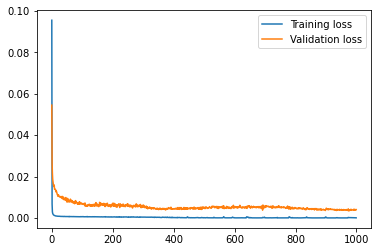

In [58]:
# plot metrics
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='Training loss')
pyplot.plot(history.history['val_loss'], label='Validation loss')

# pyplot.plot(history.history['mean_absolute_percentage_error'])
plt.legend()
pyplot.show()

In [59]:
print(history.history.keys())
print(np.argmin(np.array(history.history['val_loss']))+1)

yhat = model.predict(X_test, verbose=1)
yp = y_scaler.inverse_transform(yhat)
ya = y_scaler.inverse_transform(y_test)

dict_keys(['val_loss', 'loss'])
976
395/395 [==============================] - 0s 184us/step


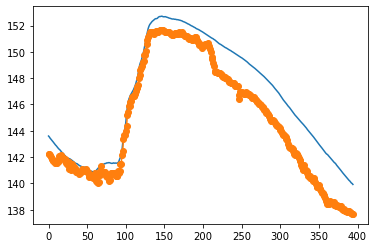

In [60]:
# T1
plt.plot(ya[:,:1])
plt.plot(yp[:,:1],marker='o')

# T2
# plt.plot(ya[:,-1:])
# plt.plot(yp[:,-1:],marker='o')

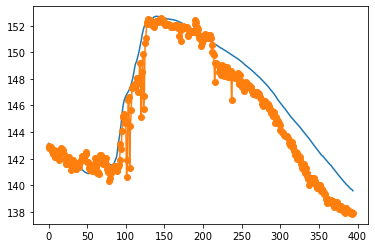

In [61]:
# T2
plt.plot(ya[:,-1:])
plt.plot(yp[:,-1:],marker='o')

In [62]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(yp, ya))
rms_total = (rms*100)/155
rms_total

1.1034961344573437

In [43]:
yact = pd.DataFrame(ya)
yact.columns = ['A1','A2','A3','A4','A5','A6','A7']
# yact.to_csv('yact.csv')

In [44]:
ypred = pd.DataFrame(yp)
ypred.columns = ['P1','P2','P3','P4','P5','P6','P7']
# ypred.to_csv('ypred.csv')

In [20]:
com = pd.concat([yact, ypred], axis=1, join='inner')
com.to_csv('com.csv')

Real-Time Test

In [113]:
from func1 import *
from query1 import *

In [114]:
df = data1()
print(df.shape)
df.index = df['datetime']
df.index = df.index.astype('datetime64[ns]')
df.sort_index(inplace=True)
df.dropna(inplace=True)
df['datetime'] = pd.to_datetime(df['datetime'])

(16, 33)


In [115]:
# df[['stor']].head(16)

In [116]:
dtat0 = df.iloc[-1:,0:1].values[0][0]
dti = pd.date_range(dtat0, periods=7).shift(1, freq='D')
dfdt = dti.to_frame(index=False, name='datims')

In [117]:
dfdt

,datims
0,2020-06-01
1,2020-06-02
2,2020-06-03
3,2020-06-04
4,2020-06-05
5,2020-06-06
6,2020-06-07


In [118]:
df.drop(('datetime'), axis=1, inplace=True)

In [119]:
df.shape

(16, 32)

In [120]:
# df.head(16)

In [121]:
from sklearn.preprocessing import MinMaxScaler
y_scaler = MinMaxScaler()
y_scaler.fit(df[['stor']])
X_scaler = MinMaxScaler()

df[['fore24', 'tail24', 'tail24_avg', 'evap', 'infl', 'losses',
       'rel1', 'rel2', 'rel3', 'rel_tol', 'engr1', 'engr2', 'engr3', 'cond1',
       'cond2', 'cond3', 'str1', 'str2', 'str3', 'run_g1', 'run_g2', 'run_g3',
       'run_c1', 'run_c2', 'run_c3', 'spillway', 'irr', 'camp', 'demand',
       'derate', 'outage', 'stor']] = X_scaler.fit_transform(df)

dfval = df.values

In [122]:
dfval.shape

(16, 32)

In [123]:
# dfval

In [124]:
n_steps_in, n_steps_out = 10, 7

In [125]:
X, y = split_sequences(dfval, n_steps_in, n_steps_out)

In [126]:
print(type(X))

<class 'numpy.ndarray'>


In [127]:
print(X.shape)

(1, 10, 31)


In [129]:
# X

In [ ]:
n_features = X.shape[2]
print(X.shape) # (5973, 3, 31) = (samples, n_steps_in, n_features)
print(y.shape) # (5973, 2) = (samples, n_steps_out)

In [81]:
X[0,:,-6:-1]

array([[   0.,    0., 8652.,   17.,   66.],
       [   0.,    0., 8428.,   17.,   66.],
       [   0.,    0., 9515.,   16.,   66.],
       [   0.,    0., 9155.,   16.,   69.],
       [   0.,    0., 8979.,   16.,   69.],
       [   0.,    0., 8638.,   16.,   69.],
       [   0.,    0., 9120.,   16.,   69.],
       [   0.,    0., 8510.,   16.,   69.],
       [   0.,    0., 8625.,   16.,   69.],
       [   0.,    0., 9365.,   14.,   69.]])

In [46]:
model_2 = ShallowConvNet(n_steps_in=n_steps_in, n_steps_out=n_steps_out, n_features=n_features)
model_2.summary()
model_2.load_weights("models/model1.hdf5")
model_2.compile(optimizer='adam', loss='mse')
Y_pred = model_2.predict(X)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 9, 64)             4032      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 4, 64)             0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 50)                12850     
_________________________________________________________________
dense_10 (Dense)             (None, 7)                 357       
Total params: 17,239
Trainable params: 17,239
Non-trainable params: 0
_________________________________________________________________


In [47]:
yp = y_scaler.inverse_transform(Y_pred)

In [48]:
yp

array([[4217.8774, 4207.0415, 4202.6206, 4185.0186, 4154.467 , 4158.8276,
        4184.68  ]], dtype=float32)